<a href="https://colab.research.google.com/github/Fdvanleeuwen/Multistep_RNN/blob/main/RNN_sim_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template for RNN's

In [138]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Data

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [220]:
# load data
#df = pd.read_csv('/content/gdrive/My Drive/LSTM/sim_data.csv')
df = pd.read_csv('/content/gdrive/My Drive/LSTM/sim_data_big.csv')

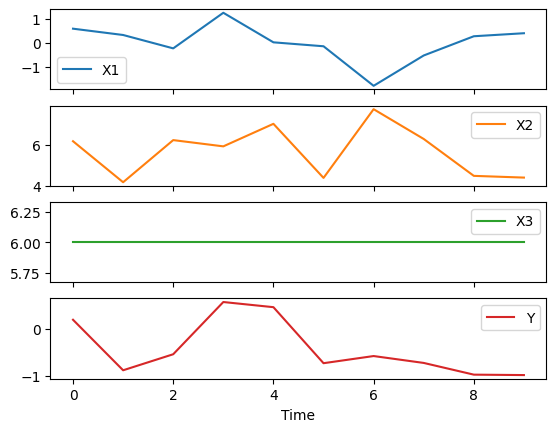

In [221]:
# plot the features for one person
plot_cols = ["X1", "X2", "X3", "Y"]
viewing_window = 10

plot_features = df[plot_cols][:viewing_window]
plot_features.index = df["Time"][:viewing_window]
_ = plot_features.plot(subplots=True)

In [196]:
# look at the statsitics of the dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,10000.0,4.500000,2.872425,0.000000,2.000000,4.500000,7.000000,9.000000
Participant,10000.0,1002.000000,577.378850,3.000000,502.500000,1002.000000,1501.500000,2001.000000
Y,10000.0,1.936475,1.118480,-0.999990,1.236074,2.000373,2.755775,3.999997
X1,10000.0,0.489188,1.111743,-4.460326,-0.268850,0.501076,1.225880,4.973283
X2,10000.0,5.513726,1.128656,1.452627,4.769406,5.503830,6.272040,9.649414
X3,10000.0,9.497000,5.698705,0.000000,5.000000,9.000000,14.000000,19.000000


In [197]:
# we need to reshape the ouput so that every person is on the thrid axis
print(df.shape)

def reshaper(df, n_participants, n_timepoints, n_var):
  out = np.zeros((n_participants, n_timepoints, n_var))

  for i in range(n_participants):
    out[i:, :, ] = df[:][(i*n_timepoints):(i*n_timepoints + n_timepoints)]

  return out

(10000, 6)


In [222]:
n_participants = 1000
n_timepoints = 10
n_var = 6

out = reshaper(df, n_participants, n_timepoints, n_var)

In [223]:
# select variables that we want to use in analysis
df_use = out[:, :, 2:]

# we will us the first 7 timepoitns of X to predict the last 3 of y

X = df_use[:, :7, 1:]

y = df_use[:, 7:, :1]

In [224]:
# check the shape
print(X.shape, y.shape)

(1000, 7, 3) (1000, 3, 1)


In [225]:
# split the data
def split_data(X, y, val_size, test_size):
  n = X.shape[0]
  draw = random.sample(range(n), n)

  val_n = int(np.floor(n * val_size))
  test_n = int(np.floor(n * test_size))
  train_n = int(n - val_n - test_n)

  X_train = X[draw[:train_n]]
  X_val = X[draw[train_n:(train_n +val_n)]]
  X_test = X[draw[(train_n + val_n):n]]

  y_train = y[draw[:train_n]]
  y_val = y[draw[train_n:(train_n +val_n)]]
  y_test = y[draw[(train_n + val_n):n]]

  return X_train, X_val, X_test, y_train, y_val, y_test

In [226]:
val_size = 0.15
test_size = 0.15

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, val_size, test_size)

In [227]:
# normalize the data
train_mean_X = np.mean(X_train, axis = 0)
train_std_X = np.std(X_train, axis = 0)
train_mean_y = np.mean(y_train, axis = 0)
train_std_y = np.std(y_train, axis = 0)

X_train = (X_train - train_mean_X) / train_std_X
X_val = (X_val - train_mean_X) / train_std_X
X_test = (X_test - train_mean_X) / train_std_X

y_train = (y_train - train_mean_y) / train_std_y
y_val = (y_val - train_mean_y) / train_std_y
y_test = (y_test - train_mean_y) / train_std_y

In [228]:
# plot results
df_std_X = (X - train_mean_X) / train_std_X
df_std_y = (y - train_mean_y) / train_std_y

In [229]:
# reshape for the plot, remove the 3rd axis
df_std_X_temp = pd.DataFrame(df_std_X.reshape(((df_std_X.shape[0]*df_std_X.shape[1]), df_std_X.shape[2])))

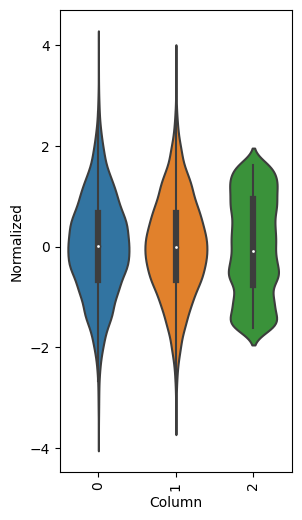

In [230]:
df_std = df_std_X_temp.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(3,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_std_X_temp.keys(), rotation=90)

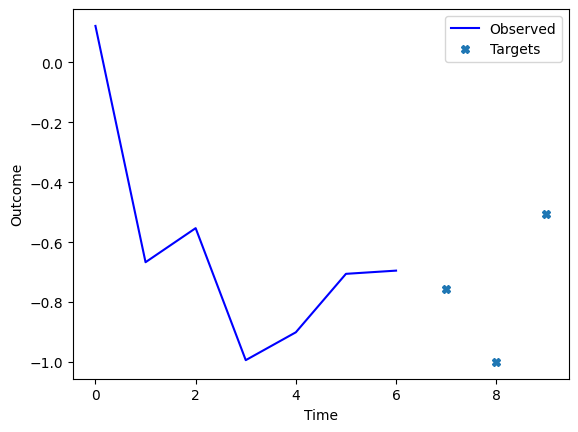

In [231]:
# create the correct windows for prediction
# is it many to one, or many to many?

# make a plot showing the window and the timepoints that will be predicted
obs = df_use[1, :7, :1]
pred = df_use[1, 7:, :1]
time = list(range(10))

plt.plot(time[:7], obs, color = "blue", label = "Observed")
plt.plot(time[7:], pred, marker = "X", linestyle='none', label = "Targets")
plt.xlabel("Time")
plt.ylabel("Outcome")
plt.legend()
plt.show()

In [232]:
# create a torch or tenserflow dataset
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()
y_test = torch.tensor(y_test).float()

In [233]:
# create a pytorch dataset
class SimDataset(Dataset):
  def __init__(self, X, y):
    self.features = X
    self.targets = y

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx): #obtain a dictionaty for a single sample
    if torch.is_tensor(idx):
      idx = idx.tolist()

    sample = {'features': self.features[idx],
              'target': self.targets[idx]}

    return sample

In [234]:
# put the variables in a dataloader, so that it is easy to use batches later
train_dataset = SimDataset(X_train, y_train)
train_val = SimDataset(X_train, y_train)
train_test = SimDataset(X_train, y_train)

batch_size = 10

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

In [235]:
# also create a dataset for simpeler models that we can use to compare the results against, e.g. logistic regression
X_simp = df

In [236]:
X_simp = df.pivot(index='Participant', columns='Time', values = ['Y', "X1", "X2", "X3"])
X_simp2 = df.pivot(index='Participant', columns='Time', values = ['Y', "X1", "X2", "X3"])

In [237]:
# drop the second level of
X_simp.columns = X_simp.columns.droplevel(0)

In [238]:
# make nice colums names
col_names = []
values = ['Y', "X1", "X2", "X3"]

for j in values :
  for i in range(n_timepoints):
    col_names.append(j+'_'+str(i))

In [239]:
X_simp.columns = col_names

## Models


In [240]:
class Encoder(nn.Module):

    def __init__(self, input_size, hidden_dim, num_layers=1):
        super(Encoder, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_dim, num_layers=self.num_layers)
        self.hidden = None

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))

    def forward(self, inputs):
        # Push through RNN layer (the ouput is irrelevant)
        _, self.hidden = self.lstm(inputs, self.hidden)
        return self.hidden


class Decoder(nn.Module):

    def __init__(self, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        # input_size=1 since the output are single values
        self.lstm = nn.LSTM(1, hidden_dim, num_layers=num_layers)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, outputs, hidden, criterion):
        batch_size, num_steps = outputs.shape
        # Create initial start value/token
        input = torch.tensor([[0.0]] * batch_size, dtype=torch.float)
        # Convert (batch_size, output_size) to (seq_len, batch_size, output_size)
        input = input.unsqueeze(0)

        loss = 0
        for i in range(num_steps):
            # Push current input through LSTM: (seq_len=1, batch_size, input_size=1)
            output, hidden = self.lstm(input, hidden)
            # Push the output of last step through linear layer; returns (batch_size, 1)
            output = self.out(output[-1])
            # Generate input for next step by adding seq_len dimension (see above)
            input = output.unsqueeze(0)
            # Compute loss between predicted value and true value
            loss += criterion(output, outputs[:, i])
        return loss

In [241]:
# 3 is the number of features of your data points
encoder = Encoder(3, 128)
decoder = Decoder(128)
# Create optimizers for encoder and decoder
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.01)
criterion = nn.MSELoss()

inputs = X_train
# Convert (batch_size, seq_len, input_size) to (seq_len, batch_size, input_size)
inputs = inputs.transpose(1,0)

# 2 sequences (to match the batch size) of length 6 (for the 6h into the future)
#outputs = [ [0.1, 0.2, 0.3, 0.1, 0.2], [0.3, 0.2, 0.1, 0.3, 0.2] ]
#outputs = torch.tensor(np.array(outputs), dtype=torch.float)
outputs = torch.squeeze(y_train)
#
# Do one complete forward & backward pass
#
for _ in range(100):
  # Zero gradients of both optimizers
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()
  # Reset hidden state of encoder for current batch
  encoder.hidden = encoder.init_hidden(inputs.shape[1])
  # Do forward pass through encoder
  hidden = encoder(inputs)
  # Do forward pass through decoder (decoder gets hidden state from encoder)
  loss = decoder(outputs, hidden, criterion)
  # Backpropagation
  loss.backward()
  # Update parameters
  encoder_optimizer.step()
  decoder_optimizer.step()
  print("Loss:", loss.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([700])) that is different to the input size (torch.Size([700, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 3.006066083908081
Loss: 3.070615768432617
Loss: 3.0016603469848633
Loss: 3.002948045730591
Loss: 3.006272315979004
Loss: 3.0045204162597656
Loss: 3.0015835762023926
Loss: 3.000091075897217
Loss: 3.000783920288086
Loss: 3.001803398132324
Loss: 3.0012965202331543
Loss: 3.0003433227539062
Loss: 3.000032424926758
Loss: 3.0003323554992676
Loss: 3.0007076263427734
Loss: 3.0007705688476562
Loss: 3.000527858734131
Loss: 3.0002145767211914
Loss: 3.0000505447387695
Loss: 3.0000994205474854
Loss: 3.000260829925537
Loss: 3.0003738403320312
Loss: 3.00034761428833
Loss: 3.000215530395508
Loss: 3.000077486038208
Loss: 3.000013589859009
Loss: 3.0000360012054443
Loss: 3.0001020431518555
Loss: 3.000155448913574
Loss: 3.0001606941223145
Loss: 3.000119209289551
Loss: 3.000058889389038
Loss: 3.0000150203704834
Loss: 3.000006914138794
Loss: 3.000030517578125
Loss: 3.0000624656677246
Loss: 3.0000786781311035
Loss: 3.0000686645507812
Loss: 3.0000414848327637
Loss: 3.0000154972076416
Loss: 3.000004768371

In [ ]:
## dev functions to run gradient decent and calcuate the loss / error

In [ ]:
# Initlisize parameters, set hyper parameters, optimizer, initialize models

# in case we want to meussure acticate weights and biases here

In [ ]:
# train the model

## Evaluation

In [213]:
# Initialize a tensor to store the generated predictions
predicted_outputs = torch.zeros(outputs.shape)

# Set the encoder hidden state
encoder.hidden = encoder.init_hidden(inputs.shape[1])

# Initialize the input tensor for the decoder
input = torch.zeros(1, inputs.shape[1], 1, dtype=torch.float)

# Iterate over the sequence length
for i in range(outputs.shape[1]):
    # Forward pass through the decoder
    output, encoder.hidden = decoder.lstm(input, encoder.hidden)
    prediction = decoder.out(output[-1])

    # Store the prediction
    predicted_outputs[:, i] = prediction.squeeze()

    # Set the prediction as the input for the next time step
    input = prediction.unsqueeze(0)

# Convert predicted_outputs to a NumPy array
predicted_outputs = predicted_outputs.detach().numpy()

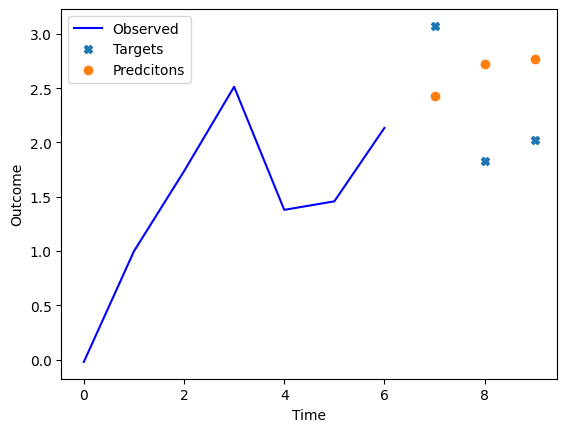

In [214]:
# CHECK if this is the right person

# transform variable back
pred = predicted_outputs[1]
pred_corr = pred*np.mean(train_std_y)+ train_mean_y.transpose()

# make a plot showing the window and the timepoints that will be predicted
obs = df_use[1, :7, :1]
target = df_use[1, 7:, :1]
time = list(range(10))

plt.plot(time[:7], obs, color = "blue", label = "Observed")
plt.plot(time[7:], target, marker = "X", linestyle='none', label = "Targets")
plt.plot(time[7:], pred_corr.transpose(), marker = "o", linestyle='none', label = "Predcitons")
plt.xlabel("Time")
plt.ylabel("Outcome")
plt.legend()
plt.show()

In [216]:
# linear model
n_samples = 1000
y_list = ['Y_7', 'Y_8', 'Y_9']
preds = np.zeros((n_samples, len(y_list)))
preds = pd.DataFrame(preds)
preds.columns = y_list

for i in y_list:
  lr = LinearRegression()

  Y = X_simp[i]

  X_use = X_simp[['X1_0',
  'X1_1',
  'X1_2',
  'X1_3',
  'X1_4',
  'X1_5',
  'X1_6',
  'X2_0',
  'X2_1',
  'X2_2',
  'X2_3',
  'X2_4',
  'X2_5',
  'X2_6',
  'X3_0',
  'X3_1',
  'X3_2',
  'X3_3',
  'X3_4',
  'X3_5',
  'X3_6']]

  lr.fit(X_use,
        Y)

  lr_preds_y7 = lr.predict(X_use)
  preds[i] = lr_preds_y7
  print(f"The MSE for {i} is {mean_squared_error(lr_preds_y7, Y)}")

The MSE for Y_7 is 0.4837608807361952
The MSE for Y_8 is 0.48171961841177846
The MSE for Y_9 is 0.493163773899406


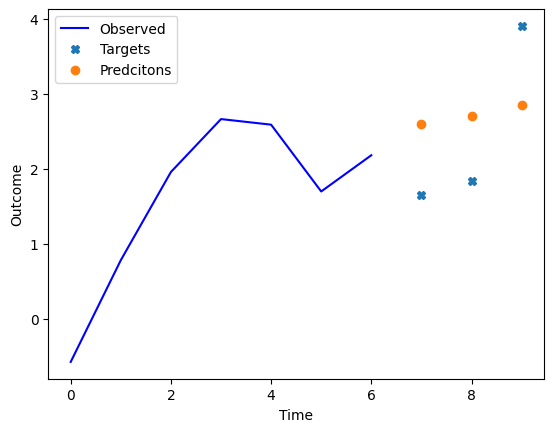

In [217]:
obs = X_simp.iloc[1,:7]
target = X_simp.iloc[1,7:10]
pred = preds.iloc[1, :]
time = list(range(10))

plt.plot(time[:7], obs, color = "blue", label = "Observed")
plt.plot(time[7:], target, marker = "X", linestyle='none', label = "Targets")
plt.plot(time[7:], pred, marker = "o", linestyle='none', label = "Predcitons")
plt.xlabel("Time")
plt.ylabel("Outcome")
plt.legend()
plt.show()

### Extra steps

In [ ]:
# include residual connections

# include uncertainty in the models estimation

# CNN's can be used to that the models still runs with different input shapes